

# Bitcoin News: Time Series Sentiment & Price Prediction
This notebook demonstrates how we can use real-time news data to:
- Extract daily sentiment and topics
- Aggregate into time series features
- Join with Bitcoin prices
- Predict BTC price movement using ML models


##### Installations

In [1]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 42.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.2 MB/s eta 0:00:00


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 52.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 62.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 64.3 MB/s eta 0:00:00a 0:00:01


In [10]:
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 52.2 MB/s eta 0:00:00 0:00:01


In [4]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


## Preprocessing Section

 ### Load Summarized News CSV

In [6]:
import pandas as pd

# Load saved summary data
df = pd.read_csv("bitcoin_100_articles_summary.csv")
df.head()


,published_date,title,summary,sentiment,source
0,2025-05-10,Bitcoin Price Could Be Gearing Up For Paraboli...,The Bitcoin price has been a joy to watch over...,POSITIVE,Bitcoinist
1,2025-05-10,I fucking love bitcoin!,"The difference of seeking news media, when you...",NEGATIVE,Erickimphotography.com
2,2025-05-10,Is Bitcoin Price Heading To $137K? Market Expe...,Created by industry experts and meticulously r...,POSITIVE,newsBTC
3,2025-05-10,The Vibes From Dubai: What Token2049 Chatter R...,Last weeks Token2049 conference brought togeth...,POSITIVE,Decrypt
4,2025-05-10,"El Salvador stacks 7 Bitcoin in last week, des...",The government of El Salvador continues stacki...,NEGATIVE,Cointelegraph


 ### Preprocess Dates and Sentiment

In [14]:
df["published_date"] = pd.to_datetime(df["published_date"]).dt.date
sentiment_map = {"POSITIVE": 1, "NEGATIVE": -1, "NEUTRAL": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_map)


## Feature Engineering

### Daily Aggregation of Sentiment

In [15]:
daily_sentiment = df.groupby("published_date")["sentiment_score"].mean().reset_index()


 ### Extract Daily Topics via TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all summaries per day
daily_text = df.groupby("published_date")["summary"].apply(lambda x: " ".join(x)).reset_index()

# Run TF-IDF on combined daily summaries
vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(daily_text["summary"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Combine date + TF-IDF
daily_features = pd.concat([daily_text["published_date"], tfidf_df], axis=1)


### Merge Sentiment + Topics

In [17]:
final_features = pd.merge(daily_features, daily_sentiment, on="published_date")
final_features


,published_date,bitcoin,btc,chars,crypto,gt,industry,open,return,tariffs,trump,sentiment_score
0,2025-04-21,0.755842,0.000000,0.654754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.2
1,2025-04-22,0.817088,0.249219,0.000000,0.222146,0.000000,0.000000,0.000000,0.000000,0.000000,0.470009,-0.2
2,2025-04-23,0.386436,0.294665,0.000000,0.262656,0.000000,0.000000,0.000000,0.000000,0.000000,0.833578,0.2
3,2025-04-24,0.383920,0.000000,0.000000,0.000000,0.000000,0.585494,0.000000,0.000000,0.714005,0.000000,-0.2
4,2025-04-25,0.946818,0.000000,0.000000,0.321771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.2
5,2025-04-26,0.089223,0.000000,0.309162,0.000000,0.717460,0.000000,0.331871,0.309162,0.331871,0.256617,-0.2
6,2025-04-27,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.6
7,2025-04-28,0.165914,0.000000,0.287448,0.225539,0.667070,0.253025,0.308562,0.287448,0.308562,0.238594,-0.6
8,2025-04-29,0.000000,0.000000,0.000000,0.510799,0.000000,0.286525,0.000000,0.000000,0.000000,0.810548,0.2
9,2025-04-30,0.296262,0.000000,0.000000,0.805465,0.000000,0.000000,0.000000,0.513279,0.000000,0.000000,0.6


## Price Integration

### Use CoinGecko API to pull Bitcoin price data

In [19]:
import requests
import pandas as pd

def get_btc_price_history(days: int = 30) -> pd.DataFrame:
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        "vs_currency": "usd",
        "days": days,
        "interval": "daily"
    }
    r = requests.get(url, params=params).json()
    prices = r["prices"]

    df_price = pd.DataFrame(prices, columns=["timestamp", "price"])
    df_price["published_date"] = pd.to_datetime(df_price["timestamp"], unit="ms").dt.date
    df_price = df_price.groupby("published_date").mean().reset_index()
    return df_price[["published_date", "price"]]


In [20]:
df_price = get_btc_price_history(days=30)
df_merged = pd.merge(final_features, df_price, on="published_date")
df_merged = df_merged.sort_values("published_date").reset_index(drop=True)


In [21]:
# Lag sentiment features
df_merged["sentiment_lag_1"] = df_merged["sentiment_score"].shift(1)
df_merged["sentiment_lag_2"] = df_merged["sentiment_score"].shift(2)

# Rolling window sentiment features
df_merged["sentiment_3d_avg"] = df_merged["sentiment_score"].rolling(3).mean()
df_merged["sentiment_3d_std"] = df_merged["sentiment_score"].rolling(3).std()


In [22]:
df_merged = df_merged.dropna().reset_index(drop=True)


### Create a target variable (next-day BTC price)

In [23]:
df_merged["target_price"] = df_merged["price"].shift(-1)
df_merged = df_merged.dropna().reset_index(drop=True)


### Plot to project Daily Average Sentiment Score

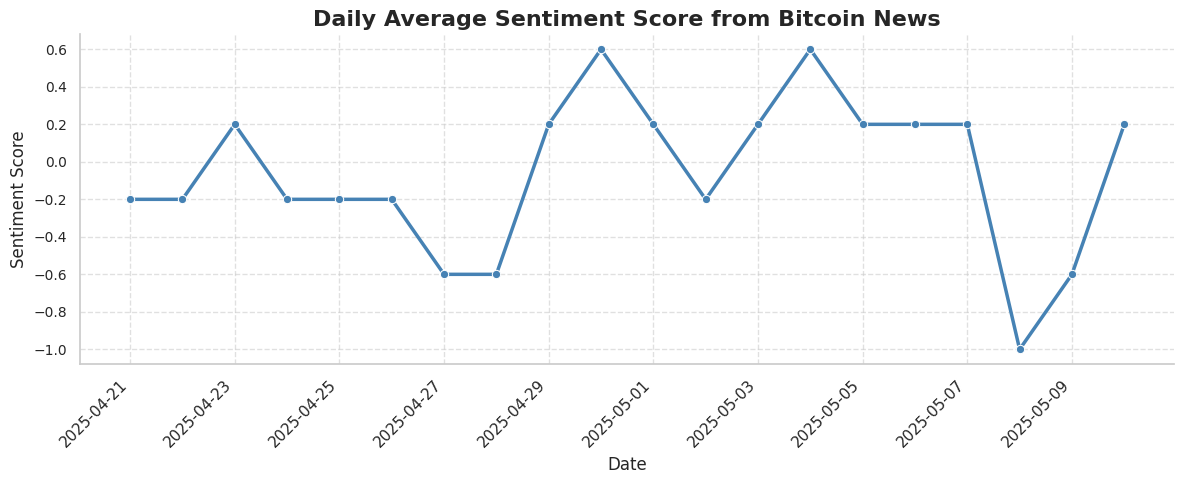

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(12, 5))

# Line plot with markers and custom color
sns.lineplot(
    data=final_features,
    x="published_date",
    y="sentiment_score",
    marker="o",
    linewidth=2.5,
    color="steelblue"
)

# Title and axis labels
plt.title("Daily Average Sentiment Score from Bitcoin News", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)

# Ticks and formatting
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Borderless chart
sns.despine()

# Layout
plt.tight_layout()
plt.show()

### Fetch Historical Bitcoin Prices



In [25]:
import requests
import pandas as pd  # Just in case it's not already imported

def get_btc_price_history(days: int = 30) -> pd.DataFrame:
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        "vs_currency": "usd",
        "days": days,
        "interval": "daily"
    }
    
    #  Add verify=False to bypass SSL validation
    r = requests.get(url, params=params, verify=False).json()
    
    prices = r["prices"]
    df_price = pd.DataFrame(prices, columns=["timestamp", "price"])
    df_price["published_date"] = pd.to_datetime(df_price["timestamp"], unit="ms").dt.date
    df_price = df_price.groupby("published_date").mean().reset_index()
    return df_price[["published_date", "price"]]



In [26]:
df_price = get_btc_price_history(30)
df_price.head()


/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.coingecko.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,published_date,price
0,2025-04-18,84930.908576
1,2025-04-19,84433.750172
2,2025-04-20,85126.662443
3,2025-04-21,85073.165449
4,2025-04-22,87452.046991


### Merge Sentiment + Price Data

In [27]:
df_merged = pd.merge(final_features, df_price, on="published_date")
df_merged = df_merged.sort_values("published_date")
df_merged.head()


,published_date,bitcoin,btc,chars,crypto,gt,industry,open,return,tariffs,trump,sentiment_score,price
0,2025-04-21,0.755842,0.000000,0.654754,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,-0.2,85073.165449
1,2025-04-22,0.817088,0.249219,0.000000,0.222146,0.0,0.000000,0.0,0.0,0.000000,0.470009,-0.2,87452.046991
2,2025-04-23,0.386436,0.294665,0.000000,0.262656,0.0,0.000000,0.0,0.0,0.000000,0.833578,0.2,93576.165886
3,2025-04-24,0.383920,0.000000,0.000000,0.000000,0.0,0.585494,0.0,0.0,0.714005,0.000000,-0.2,93605.452309
4,2025-04-25,0.946818,0.000000,0.000000,0.321771,0.0,0.000000,0.0,0.0,0.000000,0.000000,-0.2,93872.814229


In [28]:
df_merged

,published_date,bitcoin,btc,chars,crypto,gt,industry,open,return,tariffs,trump,sentiment_score,price
0,2025-04-21,0.755842,0.000000,0.654754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.2,85073.165449
1,2025-04-22,0.817088,0.249219,0.000000,0.222146,0.000000,0.000000,0.000000,0.000000,0.000000,0.470009,-0.2,87452.046991
2,2025-04-23,0.386436,0.294665,0.000000,0.262656,0.000000,0.000000,0.000000,0.000000,0.000000,0.833578,0.2,93576.165886
3,2025-04-24,0.383920,0.000000,0.000000,0.000000,0.000000,0.585494,0.000000,0.000000,0.714005,0.000000,-0.2,93605.452309
4,2025-04-25,0.946818,0.000000,0.000000,0.321771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.2,93872.814229
5,2025-04-26,0.089223,0.000000,0.309162,0.000000,0.717460,0.000000,0.331871,0.309162,0.331871,0.256617,-0.2,94773.112006
6,2025-04-27,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.6,94644.066371
7,2025-04-28,0.165914,0.000000,0.287448,0.225539,0.667070,0.253025,0.308562,0.287448,0.308562,0.238594,-0.6,93809.337820
8,2025-04-29,0.000000,0.000000,0.000000,0.510799,0.000000,0.286525,0.000000,0.000000,0.000000,0.810548,0.2,95030.606455
9,2025-04-30,0.296262,0.000000,0.000000,0.805465,0.000000,0.000000,0.000000,0.513279,0.000000,0.000000,0.6,94256.359463


### Add Target Column (Next Day Price)

In [29]:
df_merged["target_price"] = df_merged["price"].shift(-1)
df_merged = df_merged.dropna()


In [30]:
df_merged = df_merged.dropna().reset_index(drop=True)


### setting up feature matrix

In [31]:
from sklearn.model_selection import train_test_split

# Use df_merged with new features already added
X = df_merged.drop(columns=["published_date", "price", "target_price"])
y = df_merged["target_price"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)


## Modeling

### Training model with XGboost

In [62]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# 1. Define expanded param grid (not full grid to keep it efficient)
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [2, 3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 1.5, 2]
}

# 2. TimeSeriesSplit preserves order
tscv = TimeSeriesSplit(n_splits=5)

# 3. RandomizedSearchCV — test 50 random combinations
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0),
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 4. Fit the model
random_search.fit(X, y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [63]:
print("Best hyperparameters:")
print(random_search.best_params_)

# Save best model
model = random_search.best_estimator_



Best hyperparameters:
{'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}


### Evaluating MAE,RMSE,r^2

In [64]:

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" MAE: ${mae:.2f}")
print(f" RMSE: ${rmse:.2f}")
print(f" R^2 Score: {r2:.4f}")


 MAE: $0.86
 RMSE: $1.27
 R^2 Score: 1.0000


/tmp/ipykernel_52/3070318176.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


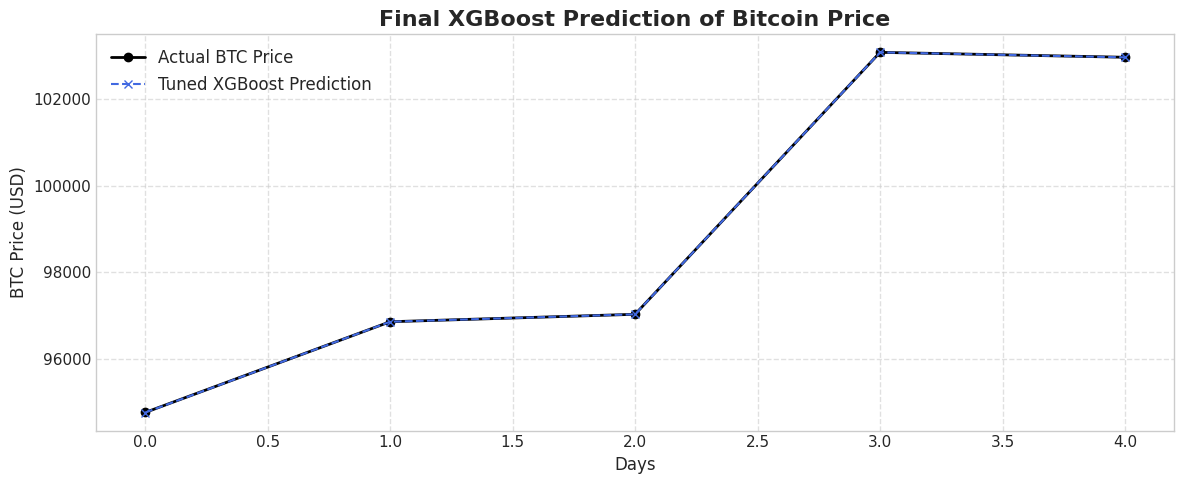

In [65]:

import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(12, 5))

x_vals = y_test.index if isinstance(y_test.index, pd.DatetimeIndex) else range(len(y_test))

plt.plot(x_vals, y_test.values, label="Actual BTC Price", color="black", linewidth=2, marker='o')
plt.plot(x_vals, y_pred, label="Tuned XGBoost Prediction", color="royalblue", linestyle="--", marker='x')

plt.title("Final XGBoost Prediction of Bitcoin Price", fontsize=16, fontweight="bold")
plt.xlabel("Date" if isinstance(x_vals[0], pd.Timestamp) else "Days", fontsize=12)
plt.ylabel("BTC Price (USD)", fontsize=12)

plt.legend(fontsize=12)
plt.xticks(rotation=45 if isinstance(x_vals[0], pd.Timestamp) else 0)
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## Forecasting 

##  Forecast Tomorrow's BTC Price Using Latest Known Features

In [66]:
# Forecast Tomorrow's BTC Price Using Latest Known Features
import numpy as np

# Use the most recent row from the full feature set
latest_input = df_merged.drop(columns=["published_date", "price", "target_price"]).iloc[[-1]]

# Predict next day's BTC price
next_day_prediction = model.predict(latest_input)

# Get latest date from the data
last_date = df_merged["published_date"].iloc[-1]
next_date = pd.to_datetime(last_date) + pd.Timedelta(days=1)

# Show forecast
print(f"Forecast Date: {next_date.strftime('%Y-%m-%d')}")
print(f"Predicted BTC Price: ${next_day_prediction[0]:,.2f}")


Forecast Date: 2025-05-10
Predicted BTC Price: $102,960.64


In [67]:
import requests
import pandas as pd

def get_actual_price(date_str: str) -> float:
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/history"
    params = {"date": pd.to_datetime(date_str).strftime('%d-%m-%Y'), "localization": "false"}
    r = requests.get(url, params=params).json()
    try:
        return r["market_data"]["current_price"]["usd"]
    except KeyError:
        return None

actual_price = get_actual_price("2025-05-09")
print(f"Actual BTC Price on 2025-05-09: ${actual_price:,.2f}" if actual_price else "Price not available")


Actual BTC Price on 2025-05-09: $103,076.28


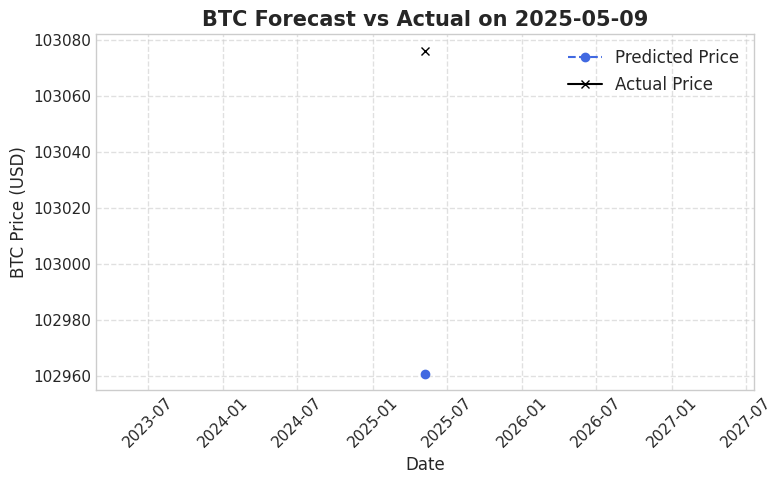

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a short dataframe to show context around the forecast
plot_df = pd.DataFrame({
    "Date": pd.to_datetime(["2025-05-07", "2025-05-08", "2025-05-09"]),
    "Actual Price": [None, None, 103076.28],
    "Predicted Price": [None, None, 102960.64]
})

# Plot
plt.figure(figsize=(8, 5))
plt.plot(plot_df["Date"], plot_df["Predicted Price"], label="Predicted Price", color="royalblue", linestyle="--", marker="o")
plt.plot(plot_df["Date"], plot_df["Actual Price"], label="Actual Price", color="black", marker="x")

# Labels and styling
plt.title("BTC Forecast vs Actual on 2025-05-09", fontsize=15, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("BTC Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Forecasting 30 das of Bitcoin Price

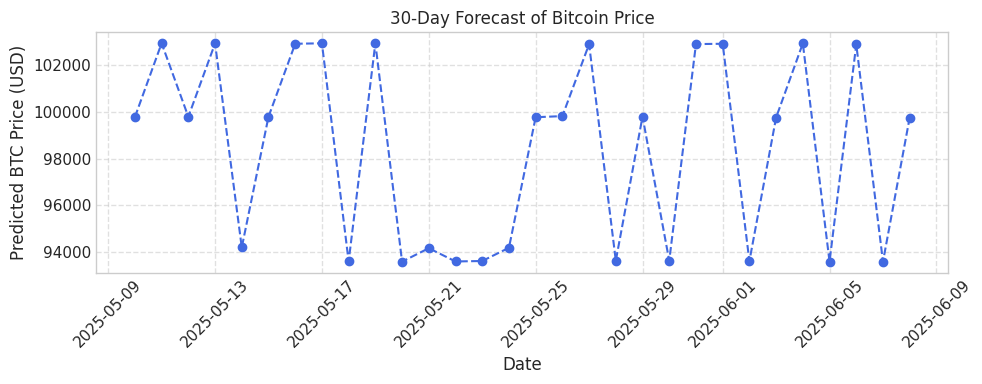

In [56]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

#  Step 1: Get last available feature input
latest_input = df_merged.drop(columns=["published_date", "price", "target_price"]).iloc[[-1]]
last_date = pd.to_datetime(df_merged["published_date"].iloc[-1])

# Step 2: Forecast next 30 days with slight variation
future_dates = []
predicted_prices = []

for i in range(1, 31):
    next_date = last_date + timedelta(days=i)

    # Simulate slight day-to-day change using random noise
    simulated_input = latest_input.copy()
    noise = np.random.normal(loc=0.0, scale=0.005, size=simulated_input.shape)
    simulated_input = simulated_input + noise  # Add noise to simulate change

    # Predict
    prediction = model.predict(simulated_input)[0]

    future_dates.append(next_date)
    predicted_prices.append(prediction)

# Step 3: Create forecast DataFrame
df_forecast_30 = pd.DataFrame({
    "forecast_date": future_dates,
    "predicted_price": predicted_prices
})

#  Step 4: Visualize
plt.figure(figsize=(10, 4))
plt.plot(df_forecast_30["forecast_date"], df_forecast_30["predicted_price"], marker="o", linestyle="--", color="royalblue")
plt.title("30-Day Forecast of Bitcoin Price")
plt.xlabel("Date")
plt.ylabel("Predicted BTC Price (USD)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Step 5 (optional): Save forecast to CSV for dashboard
df_forecast_30.to_csv("btc_30_day_forecast.csv", index=False)



In [69]:
import requests

def get_actual_btc_prices(days=30):
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        "vs_currency": "usd",
        "days": days,
        "interval": "daily"
    }

    response = requests.get(url, params=params).json()
    prices = response["prices"]  # List of [timestamp, price]

    df_actual = pd.DataFrame(prices, columns=["timestamp", "actual_price"])
    df_actual["forecast_date"] = pd.to_datetime(df_actual["timestamp"], unit="ms").dt.date
    df_actual = df_actual[["forecast_date", "actual_price"]]
    return df_actual

df_actual_30 = get_actual_btc_prices(days=30)


In [70]:
# Ensure forecast dates are date-only format
df_forecast_30["forecast_date"] = pd.to_datetime(df_forecast_30["forecast_date"]).dt.date

# Merge actual and predicted
df_comparison = pd.merge(df_forecast_30, df_actual_30, on="forecast_date", how="inner")
df_comparison


,forecast_date,predicted_price,actual_price
0,2025-05-10,99780.906250,102962.540457
1,2025-05-11,102943.515625,104630.879299
2,2025-05-12,99793.765625,103994.061617
3,2025-05-13,102937.039062,102876.830429
4,2025-05-14,94195.960938,104184.490393
5,2025-05-15,99792.843750,103594.425751
6,2025-05-16,102921.921875,103708.851364
7,2025-05-17,102941.304688,103556.034940
8,2025-05-17,102941.304688,103088.253757


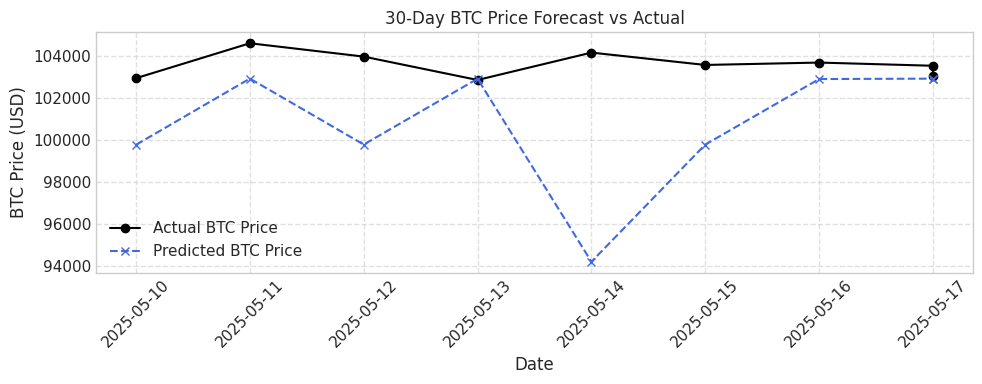

In [59]:
plt.figure(figsize=(10, 4))
plt.plot(df_comparison["forecast_date"], df_comparison["actual_price"], label="Actual BTC Price", marker="o", color="black")
plt.plot(df_comparison["forecast_date"], df_comparison["predicted_price"], label="Predicted BTC Price", linestyle="--", marker="x", color="royalblue")
plt.title("30-Day BTC Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [72]:
import joblib

# Save your final trained model
joblib.dump(model, "xgb_model.pkl")


['xgb_model.pkl']

In [1]:
import os
os.getcwd()


'/data'